# Fischer's Fritz fischt frische Fische

Let's start with defining a helper function to display multiple images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_plots(N, imgs, fig_title="",sub_titles=[]):
    """
    N     ... number of plots to show (should be < len(img))
    img   ... list of images as numpy 3D arrays (for RGB)
    title ... optional title
    """
    if not len(sub_titles):
        sub_titles = [""] * len(imgs)
    rows = (N + 3) // 4 
    select_index = np.random.choice(len(imgs),size = min(N,len(imgs)))
    select_imgs = [imgs[i] for i in select_index]
    select_titles = [sub_titles[i] for i in select_index]
    _, ax = plt.subplots(rows, 4, sharex='col', sharey='row', figsize=(20, 3 * rows))
    if fig_title:
        plt.suptitle(fig_title, y = 0.98 + .1/rows, size=20)
    for i, (img, title) in enumerate(zip(select_imgs,select_titles)):
        a = ax[i] if len(ax.shape) < 2 else ax[i // 4, i % 4]
        a.imshow(img)
        if title:
            a.set_title(title)
        a.set_axis_off()

Now it's time to load the training data. First, get a list of all image file names.

In [2]:
import glob
training_filenames = glob.glob('train/*/*.jpg')
print('Found {} training images.'.format(len(training_filenames)))

Found 3777 training images.


For future processing it may be useful to have unique identifiers for each image such that one can easily associated training and classification information (e.g. boat type, day/night etc, predicted category). We could use a database here, but let's keep it simple for the moment. We are going to use `pandas.DataFrame` and add the MD5 hash of the filename as column along with filename. In addition, we will already store the true label (i.e. the fish species).  
In order to save time in future iterations, the data frame will be saved into a `pickle` file which can be loaded in subsequent runs. Make sure that you save the data frame if you added valueable information (e.g. output from clusterisation).

In [3]:
import pandas as pd

def init_data_frame(pickle_file="df.pickle"):
    """
    load a pandas.DataFrame from given pickle file or initialise if file does not exist
    """
    import hashlib, os, pickle, re
    
    # check for pickle file and load data frame if it exists
    if os.path.isfile(pickle_file):
        print("load from pickle file '{}'".format(pickle_file))
        df = pickle.load(open(pickle_file))
        return df
    
    # no pickle file found -> create data frame
    print('create pandas.DataFrame from scratch')
    
    # get MD5 hash of filename as index
    hash = [hashlib.md5(f).hexdigest() for f in training_filenames]

    # extract true label from filename
    label_pattern = re.compile('train/([^/]+)/img_.*jpg')
    true_labels = [label_pattern.match(f).group(1)  for f in training_filenames]

    # construct the dataframe
    df = pd.DataFrame(data={'filename': training_filenames, 'hash':hash, 'true label': true_labels})
    print("save data frame to '{}'".format(pickle_file))
    df.to_pickle(pickle_file)
    return df

df = init_data_frame()
df.head()

load from pickle file 'df.pickle'


,filename,hash,true label
0,train/LAG/img_06129.jpg,f5e65e233355e0eeaf4a2aba75bc53ae,LAG
1,train/LAG/img_05005.jpg,972ad6cd602f52431a22c4c1658d5236,LAG
2,train/LAG/img_04734.jpg,e0aaacbb5e4b17702a88991bfefc527f,LAG
3,train/LAG/img_02042.jpg,4bc2ae10802cbae235f5c9bd1f196a12,LAG
4,train/LAG/img_01457.jpg,82b0643a983026b70a5920792958acd6,LAG


Finally, let's actually load some of the images. To avoid any bias, we pick the subset of training images randomly.

In [4]:
from scipy.misc import imread
import cv2

n_images = -1
if n_images > 0:
    train_df = df.sample(n_images)
else:
    train_df = df
train = np.array([cv2.resize(imread(img),dsize=(150,150)) for img in train_df['filename']])
print('Number of training images loaded {}.'.format(len(train)))

Number of training images loaded 3777.


When performing image processing, it always is important to know the dimensions of the images. So let's have a look, what we've got.

In [5]:
print('Image sizes in training sample:')
shapes = np.array([str(img.shape) for img in train])
pd.Series(shapes).value_counts()

Image sizes in training sample:


(150, 150, 3)    3777
dtype: int64

We can also plot some example images for each image size.

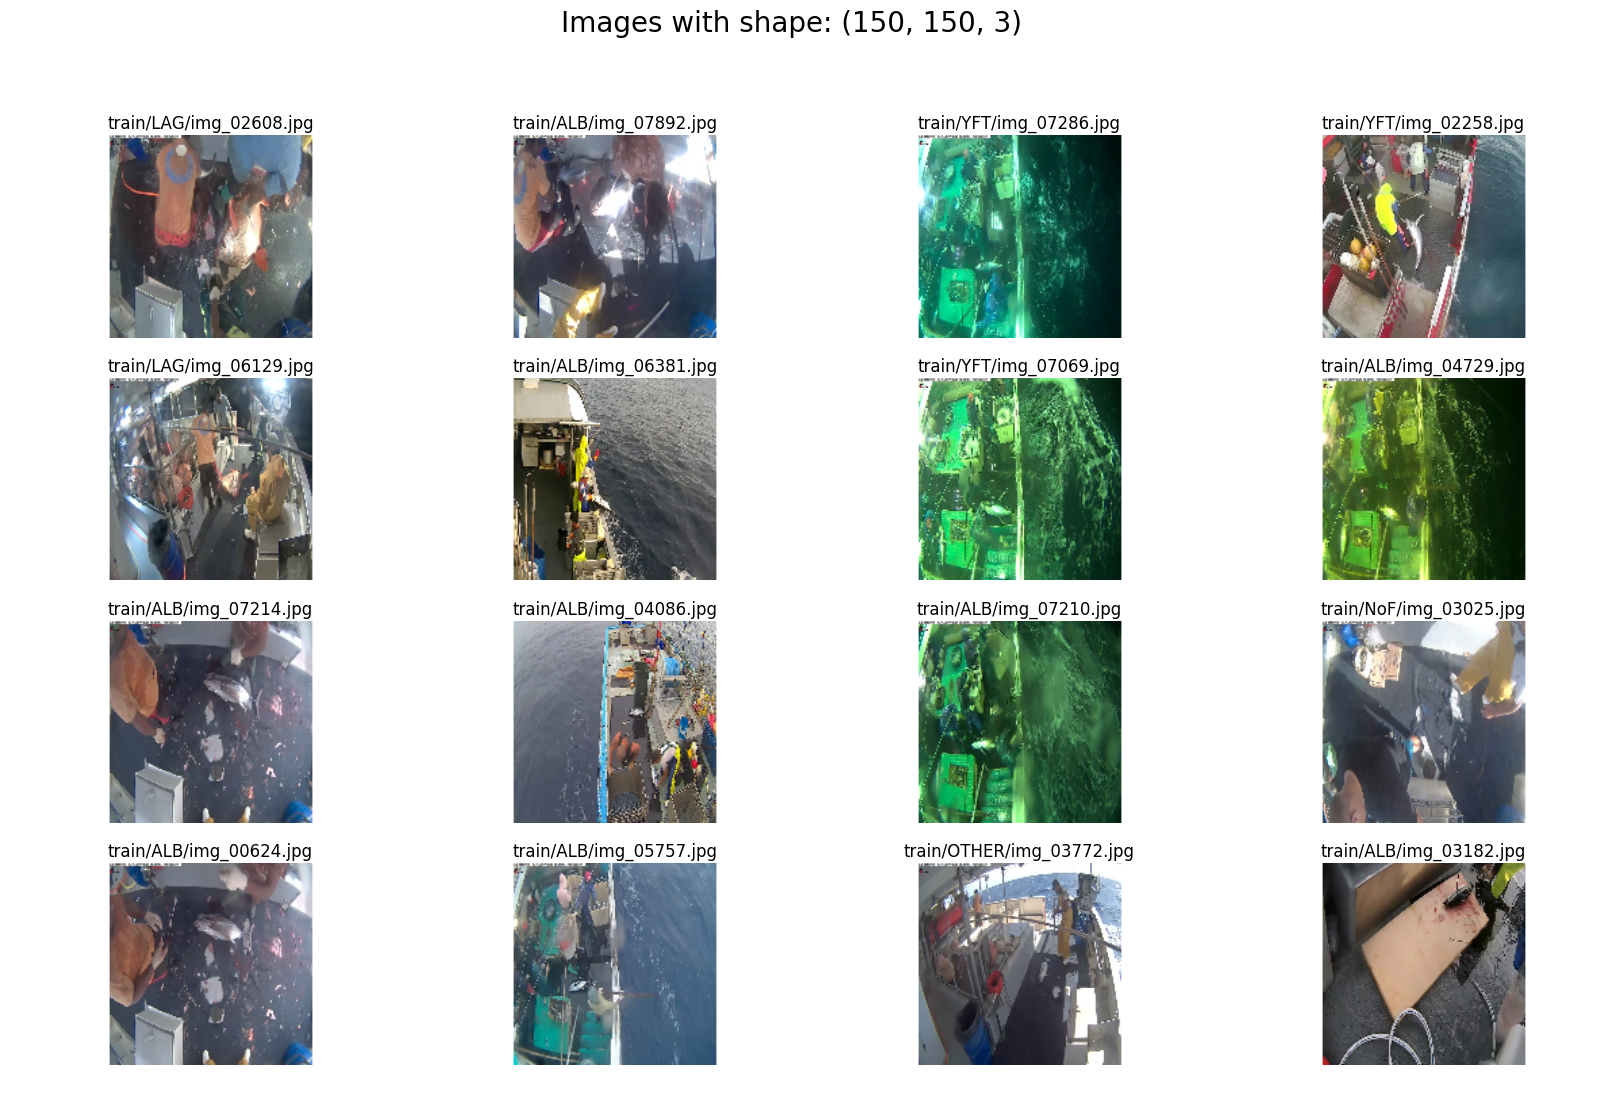

In [7]:
for uniq in pd.Series(shapes).unique():
    show_plots(16,train[shapes == uniq], 'Images with shape: {}'.format(uniq),train_df['filename'][shapes == uniq])
    plt.show()

As a first pre-processing step, we may want to try to cluster images into categories where each category corresponds to one fishing cutter. This could potentially be useful for the following steps:
* identify areas of the image which do not change (e.g. structure of the boat itself) and therefore limit the area where to look for the fish
* build a different model for each boat (my assumption is that the prior distribution for each fish species depends on the fishing region, and thus, maybe on the boat as well)
We will use `sklearn.DBSCAN` as clusterisation algorithm which requires as input the pair-wise distance matrix between all images. As a start, the distance between to images is defined as mean absolute pixel error after normalisation.

In [8]:
def calculate_image_distances(train,pickle_file = "image_distances.pickle",force_update=False):
    import multiprocessing, progressbar, pickle, os
    if os.path.isfile(pickle_file) and not force_update:
        print("load image distance matrix from pickle file '{}'".format(pickle_file))
        return pickle.load(open(pickle_file))

    # Function for computing distance between images
    def compare(args):
        img, img2 = args
        img = (img - img.mean()) / img.std()
        img2 = (img2 - img2.mean()) / img2.std()
        return np.mean(np.abs(img - img2))

    # Create the distance matrix in a multithreaded fashion
    pool = multiprocessing.Pool(4)
    distances = np.zeros((len(train), len(train)))
    bar = progressbar.ProgressBar(maxval=len(train))
    bar.start()
    for i, img in enumerate(train):
        bar.update(i+1)
        all_imgs = [(img, f) for f in train]
        dists = pool.map(compare, all_imgs)
        distances[i, :] = dists
    
    pickle.dump(distances,open(pickle_file,"w"))
    return distances

distances = calculate_image_distances(train)

load image distance matrix from pickle file 'image_distances.pickle'


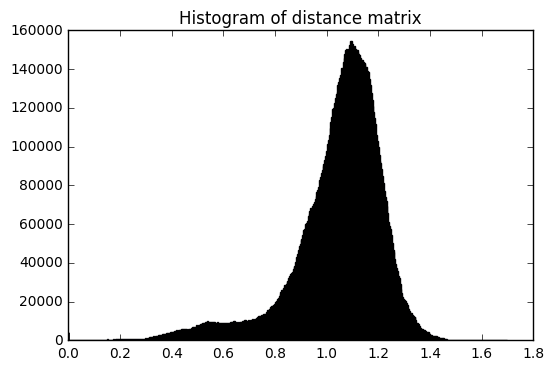

In [9]:
plt.hist(distances.flatten(), bins=500)
plt.title('Histogram of distance matrix')

In [10]:
from sklearn import cluster
cls = cluster.DBSCAN(metric='precomputed', min_samples=5, eps=0.55)
y = cls.fit_predict(distances)
train_df['boat_cluster'] = pd.Series(y,index=train_df.index)
train_df['id'] = pd.Series(np.arange(len(train_df.index)),index=df.index)
print('Cluster sizes:')
print(train_df['boat_cluster'].value_counts())

Cluster sizes:
 4     708
 1     395
 3     346
 6     336
-1     273
 0     185
 8     171
 16     93
 19     64
 46     59
 45     56
 27     46
 29     46
 35     44
 12     40
 7      40
 38     39
 60     36
 33     35
 14     35
 40     34
 22     33
 32     32
 39     29
 61     28
 2      24
 10     21
 21     20
 24     20
 53     19
      ... 
 25     11
 51     11
 57     11
 30     11
 18     10
 54     10
 49     10
 44     10
 68      9
 47      8
 71      7
 55      7
 26      7
 70      6
 42      6
 58      6
 73      6
 13      6
 34      5
 28      5
 36      5
 56      5
 64      5
 72      5
 5       5
 15      5
 69      5
 17      5
 43      5
 75      5
Name: boat_cluster, dtype: int64


In [34]:
group_3 = train[train_df[train_df.boat_cluster == 12].index]
smoothed = np.array([cv2.GaussianBlur(g,(11,11),0) for g in group_3])

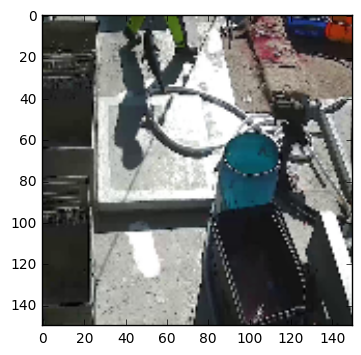

In [35]:
plt.imshow(group_3[0])

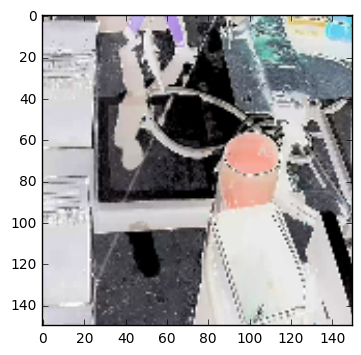

In [36]:
inverted = 255*np.ones((150,150,3),dtype=np.uint8) - group_3[0]
plt.imshow(inverted)

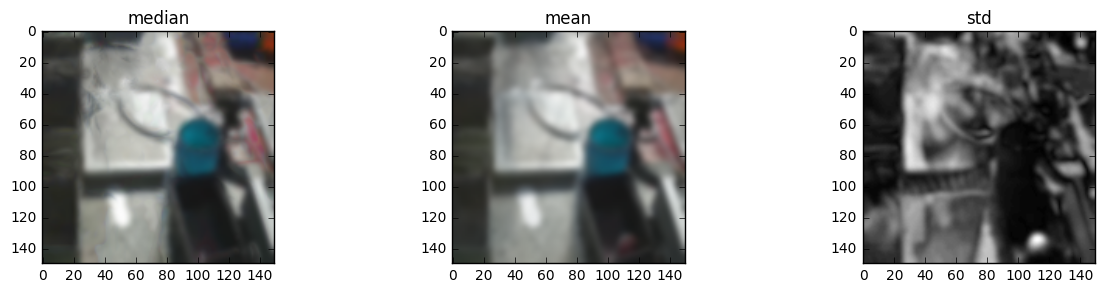

In [37]:
ref = np.median(smoothed,axis=0).astype(np.uint8)
m =  np.mean(smoothed,axis=0).astype(np.uint8)
s = smoothed.std(axis=0).astype(np.uint8)
_,ax = plt.subplots(1,3,figsize=(15,3))
ax[0].imshow(ref,cmap='gray')
ax[0].set_title('median')
ax[1].imshow(m,cmap='gray')
ax[1].set_title('mean')
ax[2].imshow(s[:,:,0],cmap='gray')
ax[2].set_title('std')

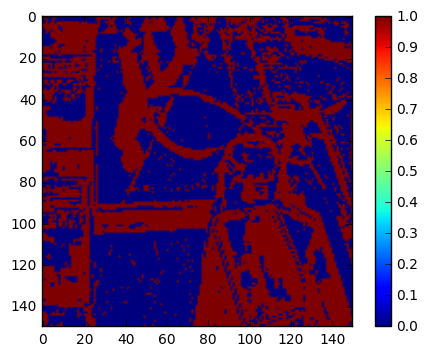

In [38]:
img = group_3[0]
darker = np.all((img.astype(np.int) - ref) < 0,axis=2)
plt.imshow(darker)
plt.colorbar()

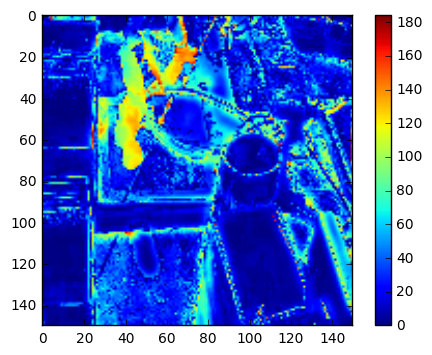

In [39]:
plt.imshow(np.abs((img.astype(np.int) - ref))[:,:,1])
plt.colorbar()

In [17]:
def to_chromaticity(img):
    c1 = np.arctan(img[:,:,0])/np.max(img[:,:,[1,2]])
    c2 = np.arctan(img[:,:,1])/np.max(img[:,:,[0,2]])
    c3 = np.arctan(img[:,:,2])/np.max(img[:,:,[0,1]])
    return np.dstack((c1,c2,c3))

trans = to_chromaticity(img)
t_ref = to_chromaticity(ref)
t_std = np.std([to_chromaticity(s).astype(np.double) for s in smoothed],axis=0)

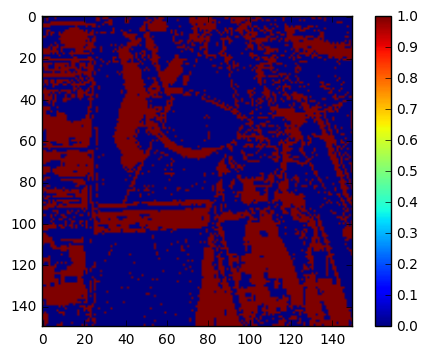

In [20]:
from matplotlib.colors import LogNorm
same = np.all(np.abs(trans - t_ref)/t_std < 5,axis=2)
plt.imshow(same & darker)
#plt.imshow(np.abs(trans - t_ref)[:,:,1], norm=LogNorm(vmin=0.00001, vmax=0.01))
plt.colorbar()

In [ ]:
img[img == 0] = 1
img2 = img.astype(float)
geo_mean = (img2[:,:,0] * img2[:,:,1] * img2[:,:,2])**(1./3)
geo_mean = geo_mean.reshape(150,150,1)
chrom = np.log2(img[:,:,:] / geo_mean)
t = np.array([1,-1,0])/np.sqrt(2)
u = np.array([-1,-1,2])/np.sqrt(6)
v = np.array([1,1,1])/np.sqrt(3)
print np.dot(t,u), np.linalg.norm(t)
print np.dot(t,v), np.linalg.norm(u)
print np.dot(u,v), np.linalg.norm(v)
proj = np.array([t,u]).transpose()
chrom2d = np.dot(chrom,proj)
print np.count_nonzero(np.isinf(chrom))

In [ ]:
from math import pi
def transform(chrom,theta):
    projector = np.array([[np.cos(theta)],[np.sin(theta)]])
    gray = np.dot(chrom,projector)
    return gray

def calc_entropy(chrom,theta):
    gray = transform(chrom,theta)
    bins,_ = np.histogram(gray.flatten(),bins=300, normed=True)
    bins = bins[bins > 0]
    entropy = -np.sum(np.log2(bins) * bins)
    return entropy

vcalc_entropy = np.vectorize(calc_entropy,excluded=[0])
thetas = np.linspace(0,pi,num=300)
entropies = vcalc_entropy(chrom2d,thetas)
plt.plot(thetas,entropies)

In [ ]:
gray = transform(chrom2d,0.5)
print np.min(gray), np.max(gray)
i = (gray - np.min(gray)) * 255. / (np.max(gray) - np.min(gray))
i = i[:,:,0].astype(np.uint8)
print np.min(i), np.max(i)
plt.imshow(gray[:,:,0],cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(img)

In [ ]:
print entropies.shape

In [ ]:
delta = cv2.absdiff(cv2.cvtColor(group_3[0],cv2.COLOR_RGB2GRAY),ref)
sig = s / np.mean(s)
print np.mean(s)
sig[sig>2] = 255#cv2.threshold(delta,1,255,cv2.THRESH_BINARY)[1]
print sig.shape
plt.imshow(delta,cmap='gray')
plt.colorbar()

In [ ]:
plt.hist(delta.flatten(),bins=50);

In [ ]:
test = train[id_group_3][0]
hsv = cv2.cvtColor(test,cv2.COLOR_RGB2HSV)
hsv[:,:,2] = cv2.threshold(hsv[:,:,2],25,255,cv2.THRESH_TRUNC)[1]
result = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
plt.imshow(hsv[:,:,2])

In [ ]:
group_3 = train[id_group_3]
print group_3.shape
GR = np.log(group_3[:,:,:,1]/(group_3[:,:,:,0]+np.ones(group_3[:,:,:,0].shape)))
BR = np.log(group_3[:,:,:,2]/(group_3[:,:,:,0]+np.ones(group_3[:,:,:,0].shape)))
plt.scatter(GR.flatten(),BR.flatten())

In [ ]:
plt.hist((group_3[0] - group_3.mean(axis=0)).flatten(),bins=50)

In [ ]:
for uniq in pd.Series(y).value_counts().index:
    if uniq != -1:
        size = len(np.array(train)[y == uniq])
        if size > 12:
            show_plots(12,np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show()
        else:
            show_plots(size,np.array(train)[y == uniq], 'BoatID: {} - Image count {}'.format(uniq, size))
            plt.show() 

In [ ]:
size = len(np.array(train)[y == -1])
show_plots(size,np.array(train)[y == -1], 'BoatID: {} (Unclassified images) - Image count {}'.format(-1, size))

In [ ]:
same = distances[y == 15][:,y==15]
plt.imshow(same,interpolation='none')
plt.colorbar()

In [ ]:
print np.arange(500)[y==28]
print np.arange(500)[y==15]
print distances[np.arange(500)[y==15],433]
show_plots(1,[train_rescaled[335]],"")

In [ ]:
mask = [e in [15,28] for e in y]
similar = [img for (img,m) in zip(train_rescaled,mask) if m]
show_plots(len(similar),similar,"same boat but different categories")

In [ ]:
from skimage import feature, color
img1 = color.rgb2gray(train_rescaled[335])
img2 = color.rgb2gray(train_rescaled[433])
edges1 = feature.canny(img1, sigma=2)
edges2 = feature.canny(img2, sigma=2)
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 6), sharex=True, sharey=True)
for i,im in enumerate([img1,edges1,img2,edges2]):
    a = ax[i // 2, i % 2]
    a.imshow(im,cmap='gray')
    a.axis('off')
    